# Topic Modeling

## Import

In [6]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.dates

import seaborn as sns

from src.progress_bar import printProgressBar

from ast import literal_eval

import gensim
import gensim.corpora as corpora
from gensim.models import TfidfModel

import pyLDAvis
import pyLDAvis.gensim_models

import spacy

import json

import os
for dirname, _, filenames in os.walk('../../data/lyrics'):
    for filename in filenames:
        print(os.path.join(dirname, filename).replace("\\", "/"))

print(50 * '-')

for dirname, _, filenames in os.walk('../../data/billboard'):
    for filename in filenames:
        print(os.path.join(dirname, filename).replace("\\", "/"))

../../data/lyrics/artist_song_lyrics.csv
../../data/lyrics/artist_song_lyrics_new.csv
../../data/lyrics/bb-t100-lyrics.csv
../../data/lyrics/bb-t100-lyrics_new.csv
../../data/lyrics/bb_t100_lyrics_en.csv
../../data/lyrics/bb_t100_lyrics_en_new.csv
../../data/lyrics/covid_lyrics_bb.csv
../../data/lyrics/lyrics_invalid.json
../../data/lyrics/lyrics_invalid_new.json
../../data/lyrics/lyrics_invalid_updated.csv
../../data/lyrics/lyrics_invalid_updated_new.csv
../../data/lyrics/backups/artist_song_lyrics_bak.csv
../../data/lyrics/backups/bb-t100-lyrics.csv
../../data/lyrics/backups/bb-t100-lyrics_new.csv
../../data/lyrics/backups/bb-t100-lyrics_old.csv
../../data/lyrics/backups/bb_t100_lyrics_en.csv
../../data/lyrics/backups/bb_t100_lyrics_en_v1.csv
../../data/lyrics/backups/bb_t100_lyrics_en_v2.csv
../../data/lyrics/backups/bb_t100_lyrics_en_v3.csv
../../data/lyrics/backups/corona-lyrics.csv
../../data/lyrics/backups/lyrics_invalid_updated.csv
----------------------------------------------

## Loading Data

In [92]:
bb_t100 = pd.read_csv('../../data/billboard/bb_t100_en.csv', index_col=0)
bb_t100['date'] = pd.to_datetime(bb_t100['date'], format='%Y-%m-%d')
bb_t100.head()

,billboard_id,lyrics_id,song,artist,peak_rank,rank_last_week,weeks_on_chart,rank,date,first_appearance,language,language_score
0,0,0,"Thank U, Next",Ariana Grande,1,1,8,1,2019-01-05,2019-01-05,en,0.999997
1,1,1,Without Me,Halsey,2,2,12,2,2019-01-05,2019-01-05,en,0.999995
2,2,2,All I Want For Christmas Is You,Mariah Carey,3,7,30,3,2019-01-05,2019-01-05,en,0.999996
3,3,3,Sicko Mode,Travis Scott,1,3,21,4,2019-01-05,2019-01-05,en,0.999998
4,4,4,Sunflower (Spider-Man: Into The Spider-Verse),Post Malone & Swae Lee,4,4,10,5,2019-01-05,2019-01-05,en,0.999997


### Lyrics

In [7]:
lyrics = pd.read_csv('../../data/lyrics/bb_t100_lyrics_en.csv', index_col=0, encoding='utf-8')
lyrics['first_appearance'] = pd.to_datetime(lyrics['first_appearance'], format='%Y-%m-%d')
lyrics['release_date'] = pd.to_datetime(lyrics['release_date'], format='%Y-%m-%d')
lyrics['genius_annotations'] = lyrics['genius_annotations'].apply(literal_eval)
lyrics['genius_comments'] = lyrics['genius_comments'].apply(literal_eval)
lyrics.reset_index(inplace=True)
lyrics.head()

,index,billboard_id,lyrics_id,artist,first_artist,song,weeks_on_chart,peak_rank,genius_id,lyrics,...,word_count,language,language_score,first_appearance,genius_primary_artist,genius_description,genius_annotations,genius_comments,release_date,annotation_ids
0,0,0,0,Ariana Grande,Ariana Grande,"Thank U, Next",28.0,1.0,4063065,Thought I'd end up with Sean\nBut he wasn't a ...,...,460,en,0.999997,2019-01-05,Ariana Grande,On the lead single and titular track to her fi...,[(One taught me love\n One taught me patience\...,"[The Mac shoutout has me fully in tears, this ...",2018-11-03,"['15720075', '15720076', '15720054', '15720247..."
1,1,1,1,Halsey,Halsey,Without Me,52.0,1.0,3977187,Found you when your heart was broke\nI filled ...,...,435,en,0.999995,2019-01-05,Halsey,“Without Me” is the first new song released by...,[(Gave love ’bout a hundred tries (Hundred tri...,[The queen is ready to snatch our wigs once ag...,2018-10-04,"['15517989', '15520369', '15518283', '15518820..."
2,2,2,2,Mariah Carey,Mariah Carey,All I Want For Christmas Is You,43.0,1.0,204233,I don't want a lot for Christmas\nThere is jus...,...,388,en,0.999996,2019-01-05,Mariah Carey,“All I Want For Christmas Is You” is an uptemp...,[(I don’t need to hang my stocking\n There upo...,"[i really like this song, it’s about that time...",1994-11-01,"['8393500', '8393500', '21611023', '8393500', ..."
3,3,3,3,Travis Scott,Travis Scott,Sicko Mode,52.0,1.0,3876994,"Astro, yeah\nSun is down, freezin' cold\nThat'...",...,771,en,0.999998,2019-01-05,Travis Scott,“SICKO MODE” refers to Travis and Drake’s work...,"[(She’s in love with who I am, [['Since Drake ...",[HAD ME OUT LIKE A LIGHT (ayy) LIKE A LIGHT (y...,2018-08-03,"['15114078', '17948214', '15113868', '15113778..."
4,4,4,4,Post Malone & Swae Lee,Post Malone,Sunflower (Spider-Man: Into The Spider-Verse),53.0,1.0,3993850,"Ayy, ayy, ayy, ayy (Ooh)\nOoh, ooh, ooh, ooh (...",...,305,en,0.999997,2019-01-05,Post Malone & Swae Lee,“Sunflower” marks the second collaboration by ...,"[(Then you’re left in the dust, unless I stuck...",[Me enjoying “Sunflower” and someone then inte...,2018-10-18,"['16057378', '16057378']"


### AZLyrics

In [8]:
import csv
import glob


def _get_csv_file_list(unzipping_output_folder):
    """
    Extract all the csv file paths given the folder path.
    :param unzipping_output_folder: Folder path.
    :return: List of CSV file paths.
    """
    csv_file_list = [i for i in glob.glob(f'{unzipping_output_folder}/**/*.csv')]
    print(f'{len(csv_file_list)} CSV files extracted.')
    return csv_file_list

azlyrics = []
def _read(csv_file_list):
    """
    Read the list of data CSVs.
    :param csv_file_list: List of CSV file paths where the data is.
    :return: CSVs read.
    """
    total = 0
    for csv_file_name in csv_file_list:
        with open(csv_file_name, 'r') as csv_file:
            rows = [row for row in csv.reader(csv_file) if row][1:]
            total += len(rows)
            print(f'{csv_file_name}: {len(rows)} songs.')
        azlyrics.append(rows)
    print(f'Total: {total}')


data_folder = '../../data/input/'
csv_file_list = _get_csv_file_list(data_folder)
_read(csv_file_list)

27 CSV files extracted.
../../data/input\azlyrics-scraper\azlyrics_lyrics_19.csv: 868 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_a.csv: 13046 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_b.csv: 22672 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_c.csv: 10296 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_d.csv: 6349 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_e.csv: 5414 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_f.csv: 2450 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_g.csv: 4542 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_h.csv: 4258 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_i.csv: 2161 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_j.csv: 11975 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_k.csv: 4610 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_l.csv: 6151 songs.
../../data/input\azlyrics-scraper\azlyrics_lyrics_m.csv: 12239 songs.
../..

In [9]:
azlyrics_data = {
    'artists' : list(),
    'artist_links' : list(),
    'songs' : list(),
    'song_links' : list(),
    'lyrics' : list()
}
for doc in azlyrics:
    for row in doc:
        if len(row) == 5:
            azlyrics_data['artists'].append(row[0])
            azlyrics_data['artist_links'].append(row[1])
            azlyrics_data['songs'].append(row[2])
            azlyrics_data['song_links'].append(row[3])
            azlyrics_data['lyrics'].append(row[4])

azlyrics_df = pd.DataFrame(data=azlyrics_data)
azlyrics_df.head()

,artists,artist_links,songs,song_links,lyrics
0,03 greedo,https://www.azlyrics.com/19/03greedo.html,sweet lady,https://www.azlyrics.com/lyrics/03greedo/sweet...,"its only one, 03, i'm from grape street, where..."
1,03 greedo,https://www.azlyrics.com/19/03greedo.html,mafia business,https://www.azlyrics.com/lyrics/03greedo/mafia...,"you gonna make me put you in a suit and tie, s..."
2,03 greedo,https://www.azlyrics.com/19/03greedo.html,paranoid,https://www.azlyrics.com/lyrics/03greedo/paran...,"we could kill it, yeah, we could, we could, we..."
3,03 greedo,https://www.azlyrics.com/19/03greedo.html,never bend,https://www.azlyrics.com/lyrics/03greedo/never...,"yeah, you lil bitch ass niggas steady speaking..."
4,03 greedo,https://www.azlyrics.com/19/03greedo.html,prayer for my lost,https://www.azlyrics.com/lyrics/03greedo/praye...,"x loaded up bro, never see me in the church, p..."


## Tokenization

### Lyrics

In [10]:
nlp = spacy.load("en_core_web_lg")
nlp.Defaults.stop_words |= {'ai', 'gon', '\u2005', 'ooh', 'let', 've', 'gonna', 'woah', 'gotta', 'll', 'mmm', 'maybe',
                            'got', 'oh', 'uh', 'want', 'huh', 'ah', 'ma', 'hey', 'woo', 'ain', 'come', 'goin', 'ya',
                            'la', 'bah', 'yeah', 'ayy', 'em', 'tryna', 'goes', 'damn', 'ooo', 'comin', 'ran', 'wanna',
                            'okay', 'til', 'didn', "i\'mma", "mi", "da", "dem", "gyal", "yuh", "fi", "di", "nuh", "ni", "yo", "dum", "gal" "wi", "w", "inna"}

In [11]:
def create_doc(text, pos_tags=["NOUN", 'PROPN', "VERB", "ADJ"]):
    lemmas = []
    doc = nlp(text)
    for token in doc:
        if token.is_stop or token.is_punct:
            continue

        if token.pos_ in pos_tags:
            if token.lemma_ not in nlp.Defaults.stop_words:
                lemmas.append(token.lemma_.lower())
            else:
                continue

    return lemmas


In [12]:
try:
    with open("../../data/cache/topic_docs.txt", "r") as f:
        lyrics_docs = json.load(f)
    f.close()
except FileNotFoundError:
    docs = []
    i = 0
    l = len(lyrics['lyrics'])
    printProgressBar(i, l, prefix='Progress:', suffix='Complete', length=50)
    for text in lyrics['lyrics']:
        lyrics_docs.append(create_doc(text))
        i+=1
        printProgressBar(i, l, prefix='Progress:', suffix='Complete', length=50)

    with open("../../data/cache/topic_docs.txt", "w") as f:
        json.dump(lyrics_docs, f)
    f.close()


### AZLyrics

In [13]:
from spacy.language import Language
from langdetect import DetectorFactory
from spacy_langdetect import LanguageDetector

@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector(language_detection_function=None)

nlp.add_pipe('language_detector')

In [14]:
def create_doc(text, pos_tags=["NOUN", 'PROPN', "VERB", "ADJ"]):
    lemmas = []
    doc = nlp(text)
    if doc._.language['language'] == 'en' and doc._.language['score'] > 0.95:
        for token in doc:
            if token.is_stop or token.is_punct:
                continue

            if token.pos_ in pos_tags:
                if token.lemma_ not in nlp.Defaults.stop_words:
                    lemmas.append(token.lemma_.lower())
                else:
                    continue
    return lemmas

In [15]:
import random

try:
    with open("../../data/cache/azlyrics_docs.txt", "r") as f:
        azlyrics_docs = json.load(f)
    f.close()
except FileNotFoundError:
    # random_lyrics = azlyrics_data['lyrics']
    # random.shuffle(random_lyrics)
    # texts = random_lyrics[:500]
    texts = azlyrics_data['lyrics'] #very time consuming
    azlyrics_docs = []
    i = 0
    l = len(texts)
    printProgressBar(0, l, prefix='Progress:', suffix='Complete', length=50)
    for text in texts:
        if text:
            azlyrics_docs.append(create_doc(text))
        i+=1
        printProgressBar(i, l, prefix='Progress:', suffix='Complete', length=50)
    with open("../../data/cache/azlyrics_docs.txt", "w") as f:
        json.dump(azlyrics_docs, f)
    f.close()

## Generate Corpus and Id2Word-Dictionary

global id2word dictionary to have consistent id and word mapping

In [16]:
all_docs = lyrics_docs.copy()
all_docs.extend(azlyrics_docs)
id2word = corpora.Dictionary(all_docs)

### Lyrics

In [17]:
def optimize_corpus(corpus, id2word, words_missing_in_tfidf = [], low_value= 0.03):
    tfidf = TfidfModel(corpus, id2word=id2word)
    dropped_words = []
    l = len(corpus)
    for i in range(0, l):
        bow = corpus[i]
        tfidf_ids = [tfidf_id for tfidf_id, tfidf_value in tfidf[bow]]
        bow_ids = [bow_id for bow_id, bow_value in bow]
        low_value_words = [tfidf_id for tfidf_id, tfidf_value in tfidf[bow] if tfidf_value < low_value]
        drops = low_value_words+words_missing_in_tfidf
        for word_id in drops:
            dropped_words.append(id2word[word_id])
        words_missing_in_tfidf = [bow_id for bow_id in bow_ids if bow_id not in tfidf_ids]
        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
        corpus[i] = new_bow
        printProgressBar(i+1, l, prefix='Progress:', suffix='Complete', length=50)
    return corpus, dropped_words, words_missing_in_tfidf

In [18]:
lyrics_corpus = [id2word.doc2bow(doc) for doc in lyrics_docs]

lyrics_corpus = optimize_corpus(lyrics_corpus, id2word)[0]

Progress: |██████████████████████████████████████████████████| 100.0% Complete


### AZLyrics

In [19]:
azlyrics_corpus = [id2word.doc2bow(doc) for doc in azlyrics_docs]

azlyrics_corpus = optimize_corpus(azlyrics_corpus, id2word)[0]

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [20]:
azlyrics_corpus

[[(26, 10),
  (75, 12),
  (143, 6),
  (218, 5),
  (255, 3),
  (288, 4),
  (433, 4),
  (466, 1),
  (501, 6),
  (571, 1),
  (572, 2),
  (592, 1),
  (599, 2),
  (657, 2),
  (766, 2),
  (779, 1),
  (784, 3),
  (809, 3),
  (841, 4),
  (846, 2),
  (1000, 2),
  (1021, 4),
  (1027, 1),
  (1048, 3),
  (1159, 4),
  (1173, 2),
  (1233, 3),
  (1380, 1),
  (1517, 2),
  (1521, 6),
  (1765, 3),
  (1791, 3),
  (1846, 3),
  (1938, 1),
  (1957, 5),
  (2014, 2),
  (2360, 1),
  (2456, 6),
  (2733, 3),
  (2911, 1),
  (3000, 1),
  (3168, 1),
  (3534, 1),
  (3553, 2),
  (3689, 1),
  (3798, 1),
  (3956, 1),
  (4062, 4),
  (4312, 4),
  (4448, 8),
  (4660, 1),
  (5676, 1),
  (6541, 1),
  (6544, 1),
  (6708, 1),
  (7157, 4),
  (7817, 1),
  (8669, 1),
  (8721, 2),
  (9456, 1),
  (10565, 1),
  (10629, 2),
  (10758, 3),
  (11370, 1),
  (12086, 4),
  (12561, 12),
  (13149, 1),
  (13150, 1),
  (13151, 3),
  (13152, 1),
  (13153, 6),
  (13154, 3),
  (13155, 1),
  (13156, 1),
  (13157, 1),
  (13158, 2),
  (13159, 1),
 

## Modeling

### LDA Model for AZLyrics

In [21]:
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import Metric

class ProgressBar(Metric):
    """Metric class for perplexity evaluation."""
    def __init__(self, corpus=None, logger=None, viz_env=None, title=None, passes=None):
        self.corpus = corpus
        self.logger = logger
        self.viz_env = viz_env
        self.title = title
        self.i = 0
        self.passes = passes

    def get_value(self, **kwargs):
        self.i+=1
        printProgressBar(self.i, self.passes, prefix='Progress:', suffix='Complete', length=50)


In [22]:
try:
    azlyrics_lda_model = gensim.models.ldamodel.LdaModel.load('../../gensim/models/azlyrics_lda')
except FileNotFoundError:
    progress_bar = ProgressBar(corpus=azlyrics_corpus, logger='shell', passes=20)
    azlyrics_lda_model = gensim.models.ldamodel.LdaModel(corpus=azlyrics_corpus,
                                                         id2word=id2word,
                                                         num_topics=7,
                                                         chunksize=5000,
                                                         passes=20,
                                                         alpha='auto',
                                                         iterations=200,
                                                         random_state=1,
                                                         callbacks=[progress_bar])
    azlyrics_lda_model.save('../../gensim/models/azlyrics_lda')

Topic Visualization

In [41]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(azlyrics_lda_model, azlyrics_corpus, id2word)

c:\users\fried\documents\1_bildung\2_programmierung\python\datascience\chart-lyrics-analysis\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.001031 -0.249201       1        1  29.076366
5      0.081120 -0.176819       2        1  19.232487
6     -0.167613  0.027845       3        1  16.517923
2     -0.206687  0.147769       4        1  13.677835
1      0.102339 -0.153617       5        1  11.280491
4     -0.164436  0.149597       6        1   6.677991
3      0.354246  0.254427       7        1   3.536907, topic_info=       Term           Freq          Total Category  logprob  loglift
32     love  165477.000000  165477.000000  Default  30.0000  30.0000
63     baby   67612.000000   67612.000000  Default  29.0000  29.0000
26     know  146148.000000  146148.000000  Default  28.0000  28.0000
194    girl   52070.000000   52070.000000  Default  27.0000  27.0000
501   nigga   49949.000000   49949.000000  Default  26.0000  26.0000
...     ...            ...            ...      ...      ...      ...
2221    son    1550.160683    5147.934588   Topic7  -5.2683   2.1417
1253   pray    1694.216824    7035.338685   Topic7  -5.1794   1.9182
997   earth    1524.035279    5416.171937   Topic7  -5.2853   2.0739
796    bear    1602.668986    8320.046874   Topic7  -5.2349   1.6949
1003  peace    1243.857016    5382.044776   Topic7  -5.4884   1.8771

[488 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
540       1  0.103641     alive
540       2  0.896213     alive
1878      1  0.912376   alright
1878      6  0.087569   alright
5850      3  0.998899  american
...     ...       ...       ...
304       1  0.144455     young
304       2  0.012038     young
304       3  0.217077     young
304       4  0.349022     young
304       5  0.277424     young

[983 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 7, 3, 2, 5, 4])

## Calculate Topics for Lyrics

Topic interpreatation based on LDA visualisation.

In [38]:
topic_names = {
    0 : 'love',
    1 : 'death / pain',
    2 : 'home / family',
    3 : 'explicit language',
    4 : 'time / weather',
    5 : 'party',
    6 : 'spirituality'
}

In [29]:
def get_topics(index, lda_corpus):
    topics = {}
    for lda_tuple in lda_corpus[index]:
        topics[lda_tuple[0]] = lda_tuple[1]
    return dict(sorted(topics.items(), key=lambda item: item[1], reverse=True))

In [30]:
def get_topics_str(topics):
    return [topic_names[topic] for topic in topics.keys()]

In [39]:
lda_corpus = azlyrics_lda_model[lyrics_corpus]
for topic_id in topic_names.keys():
    lyrics['topic_'+str(topic_id)] = 0


lyrics['topics'] = [get_topics(i, lda_corpus) for i in range(0, len(lyrics))]
lyrics['top_topic'] = lyrics['topics'].apply(lambda topic: list(topic.keys())[0])
lyrics['topics_str'] = lyrics['topics'].apply(lambda topics: [topic_names[topic] for topic in topics.keys()])
lyrics['top_topic_str'] = lyrics['top_topic'].apply(lambda topic: topic_names[topic])
lyrics['#topics'] = lyrics['topics'].apply(lambda topics: len(topics))
lyrics[['topics', '#topics','topics_str', 'top_topic', 'top_topic_str']].head()

,topics,#topics,topics_str,top_topic,top_topic_str
0,"{3: 0.42566013, 0: 0.26730767, 2: 0.17612785, ...",6,"[explicit language, love, home / family, spiri...",3,explicit language
1,"{0: 0.6546365, 4: 0.15131053, 1: 0.087675735, ...",6,"[love, time / weather, death / pain, party, ho...",0,love
2,"{1: 0.5889323, 0: 0.19178207, 4: 0.15947455, 6...",4,"[death / pain, love, time / weather, spiritual...",1,death / pain
3,"{2: 0.41166314, 6: 0.29120725, 1: 0.13944747, ...",6,"[home / family, spirituality, death / pain, pa...",2,home / family
4,"{5: 0.3441318, 0: 0.2366148, 6: 0.23469879, 4:...",5,"[party, love, spirituality, time / weather, ho...",5,party


In [40]:
lyrics_topics = lyrics[
    ['billboard_id', 'lyrics_id', 'artist', 'song', 'weeks_on_chart', 'peak_rank', 'lyrics', 'url', 'first_appearance',
     'release_date', 'topics', '#topics', 'top_topic', 'top_topic_str', 'topics_str']]
# lyrics_topics = lyrics[
#     ['billboard_id', 'lyrics_id', 'artist', 'song', 'weeks_on_chart', 'peak_rank', 'lyrics', 'url', 'first_appearance',
#      'release_date', 'topics', 'top_topic']]
lyrics_topics.to_excel('../../data/topic_modeling/bb_t100_topics.xlsx')

In [45]:
def populate_topic_col(topics, topic_id):
    if topic_id in topics.keys():
        return 1
    return 0

In [46]:
for topic_id in topic_names.keys():
    lyrics['topic_'+str(topic_id)] = lyrics['topics'].apply(lambda topics: populate_topic_col(topics, topic_id))

lyrics

,index,billboard_id,lyrics_id,artist,first_artist,song,weeks_on_chart,peak_rank,genius_id,lyrics,...,topics_str,top_topic_str,#topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,0,0,0,Ariana Grande,Ariana Grande,"Thank U, Next",28.0,1.0,4063065,Thought I'd end up with Sean\nBut he wasn't a ...,...,"[explicit language, love, home / family, spiri...",explicit language,6,1,1,1,1,0,1,1
1,1,1,1,Halsey,Halsey,Without Me,52.0,1.0,3977187,Found you when your heart was broke\nI filled ...,...,"[love, time / weather, death / pain, party, ho...",love,6,1,1,1,0,1,1,1
2,2,2,2,Mariah Carey,Mariah Carey,All I Want For Christmas Is You,43.0,1.0,204233,I don't want a lot for Christmas\nThere is jus...,...,"[death / pain, love, time / weather, spiritual...",death / pain,4,1,1,0,0,1,0,1
3,3,3,3,Travis Scott,Travis Scott,Sicko Mode,52.0,1.0,3876994,"Astro, yeah\nSun is down, freezin' cold\nThat'...",...,"[home / family, spirituality, death / pain, pa...",home / family,6,1,1,1,0,1,1,1
4,4,4,4,Post Malone & Swae Lee,Post Malone,Sunflower (Spider-Man: Into The Spider-Verse),53.0,1.0,3993850,"Ayy, ayy, ayy, ayy (Ooh)\nOoh, ooh, ooh, ooh (...",...,"[party, love, spirituality, time / weather, ho...",party,5,1,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,1317,10459,1317,Eminem,Eminem,Gnat,1.0,60.0,6285862,"Yeah, yeah, sick\n(d.a. got that dope)\n\nThey...",...,"[spirituality, home / family, party, death / p...",spirituality,5,0,1,1,0,1,1,1
1251,1318,10477,1318,Gabby Barrett,Gabby Barrett,The First Noel,1.0,78.0,6086107,"The First Noel, the Angels did say\nWas to cer...",...,"[death / pain, explicit language, love, party,...",death / pain,5,1,1,0,1,0,1,1
1252,1319,10483,1319,Popp Hunna,Popp Hunna,Adderall (Corvette Corvette),1.0,84.0,6110220,"(Bitch)\nCorvette, Corvette\nHop in a motherfu...",...,"[home / family, love, spirituality, party]",home / family,4,1,0,1,0,0,1,1
1253,1320,10492,1320,Lil Durk,Lil Durk,Backdoor,1.0,93.0,6270159,"(Malik on the beat)\n(Ayo Bleu)\nNo, no, no, n...",...,"[home / family, spirituality, love, time / wea...",home / family,5,1,0,1,0,1,1,1


In [51]:
lyrics.columns

Index(['index', 'billboard_id', 'lyrics_id', 'artist', 'first_artist', 'song',
       'weeks_on_chart', 'peak_rank', 'genius_id', 'lyrics', 'url', 'length',
       'word_count', 'language', 'language_score', 'first_appearance',
       'genius_primary_artist', 'genius_description', 'genius_annotations',
       'genius_comments', 'release_date', 'annotation_ids', 'topics',
       'top_topic', 'topics_str', 'top_topic_str', '#topics', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6',
       'month', 'year'],
      dtype='object')

In [71]:
lyrics['month'] = lyrics['first_appearance'].dt.month
lyrics['year'] = lyrics['first_appearance'].dt.year
lyrics['year-month'] = lyrics['first_appearance'].apply(lambda fa : str(fa.year) + '-' + str(fa.month))

In [93]:
merge_cols = ['genius_id', 'lyrics', 'release_date', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'url', 'lyrics_id']
bb_t100_topics = bb_t100.merge(lyrics[merge_cols], how='left', left_on='lyrics_id', right_on='lyrics_id',copy=False)
bb_t100_topics.to_csv('../../data/topic_modeling/bb_t100_topics.csv')
bb_t100_topics.to_excel('../../data/topic_modeling/bb_t100_topics.xlsx')

In [96]:
lyrics_topics_dt = pd.pivot_table(bb_t100_topics, index='date',
               values=['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6'],
               aggfunc='sum').reset_index()
lyrics_topics_dt

,date,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,2019-01-05,89,78,55,27,58,76,82
1,2019-01-12,86,70,60,23,56,82,81
2,2019-01-19,85,70,62,21,58,83,82
3,2019-01-26,86,68,61,20,60,83,82
4,2019-02-02,86,66,62,26,56,80,81
...,...,...,...,...,...,...,...,...
100,2020-12-05,90,68,60,22,68,74,80
101,2020-12-12,79,65,47,18,59,59,70
102,2020-12-19,87,69,50,21,60,66,77
103,2020-12-26,92,79,55,30,64,76,85


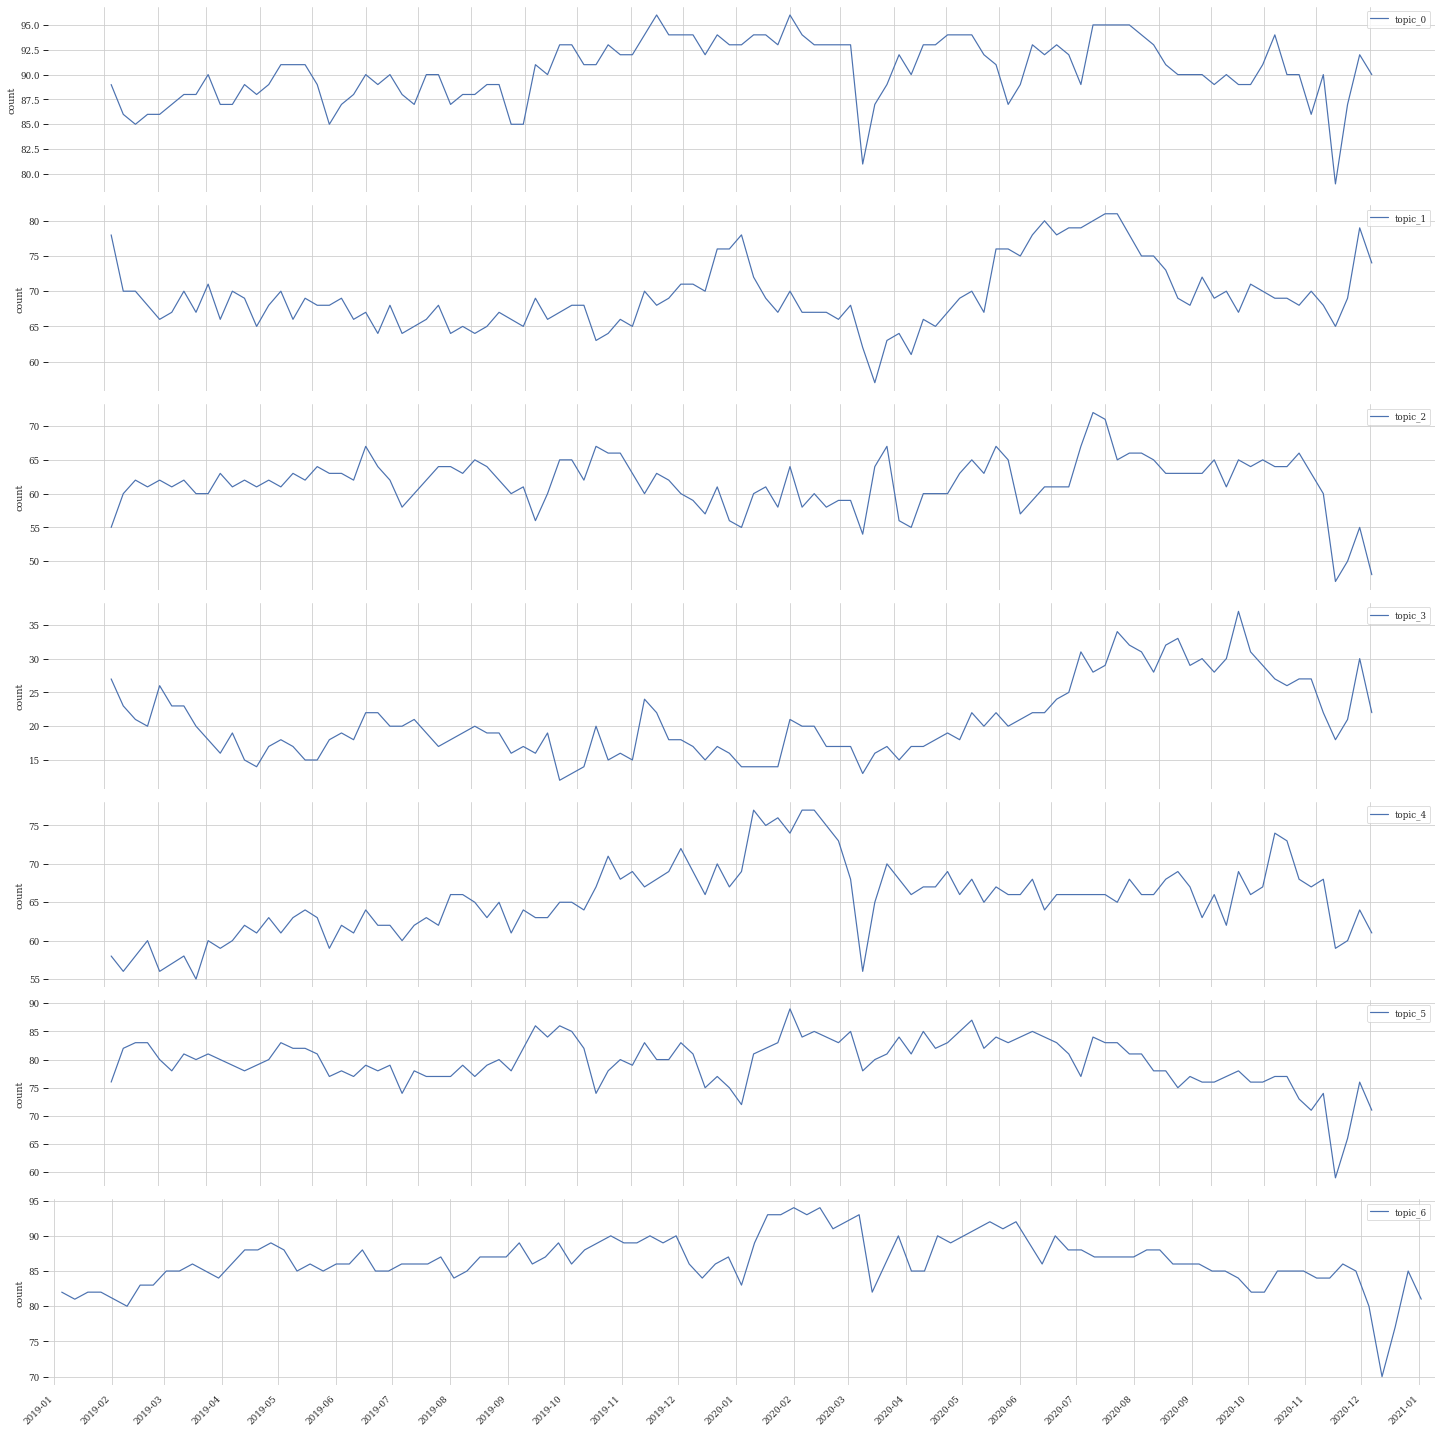

In [98]:

sns.set_theme(context='paper', font='serif', style='whitegrid')
sns.set_style({'axes.grid' : False})

fig = plt.figure(figsize=(20,20))
axes = fig.subplots(7)

ax_index=0
for topic_col in ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6']:
    sns.lineplot(data=lyrics_topics_dt, x='date', y=topic_col, label=topic_col, ax=axes[ax_index])
    ax_index+=1


loc = matplotlib.dates.MonthLocator(interval=1)
for ax in axes:
    ax.tick_params(axis="y", labelleft=True, labelright=False, left=True, right=False)
    for k,v in ax.spines.items():
        v.set_visible(False)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(matplotlib.dates.AutoDateFormatter(loc))
    ax.set_xlabel(xlabel=None)
    ax.set_ylabel(ylabel='count')
    ax.grid()
    plt.gcf().autofmt_xdate()


# ax1b.set_ylabel(ylabel=None)
# ax2b.set_ylabel(ylabel=None)
# ax2a.set_ylabel(ylabel='# of COVID-19 Deaths', labelpad=35)
# ax1a.set_ylabel(ylabel='Polarity Score', labelpad=35)

# ax1a.set_ylim(0, 0.2)
# ax1b.set_ylim(0, 0.2)
plt.xticks(rotation=45, ha='right')

plt.margins(x=0.01,tight=True)


# ax.legend(loc='upper right')


plt.tight_layout()
# plt.savefig('../../data/output/figures/bb_t100_sentiment.eps')
plt.show()
plt.close()